# Importing Libraries

In [69]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization, Attention
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Input, LSTM, Dense, Concatenate, Dot, Activation
from keras.layers import RepeatVector, TimeDistributed
from keras.models import Model



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Dataset

In [2]:
Crema = "/kaggle/input/cremad/AudioWAV/"

In [3]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


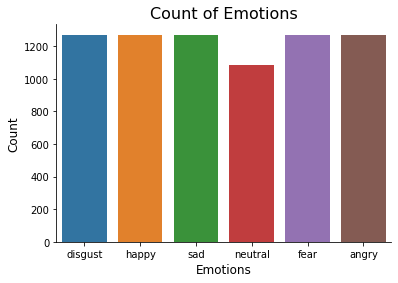

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Visualization

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

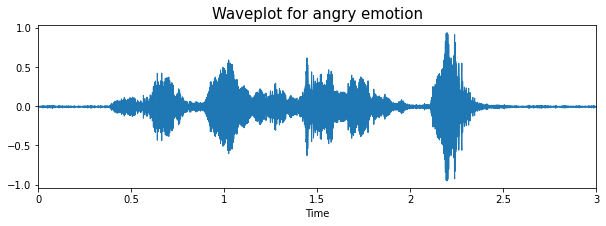

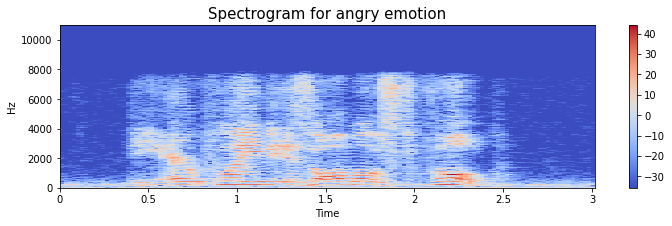

In [7]:
emotion='angry'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# MFCC Extraction

In [8]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
Crema_df.replace({'Emotions':labels},inplace=True)

In [9]:
num_mfcc=13
n_fft=2048
hop_length=512
SAMPLE_RATE = 22050
data = {
        "labels": [],
        "mfcc": []
    }
for i in range(7442):
    data['labels'].append(Crema_df.iloc[i,0])
    signal, sample_rate = librosa.load(Crema_df.iloc[i,1], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    if i%500==0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


# Padding MFCC to make them of equal length

In [10]:
X = np.asarray(data['mfcc'])
y = np.asarray(data["labels"])

In [11]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(7442, 216, 13)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [13]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(5357, 216, 13) (5357,) (1340, 216, 13) (1340,) (745, 216, 13) (745,)


# Model

In [118]:
# lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
def build_model(input_shape):
    model = tf.keras.Sequential()
    
    
#     lstm = tf.keras.layers.LSTM(output_dim)(inputs)
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
#     model.add(LSTM(64))
    model.add(tf.keras.layers.Attention((None, None, 128)))
#     attt = Attention()
#     model.add(attt)

    
#     print("Test Accuracy: ",test_acc)
#     lstm = tf.keras.layers.LSTM(output_dim)(inputs)
#     model.add(Attention((None, 64),64))   
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
#     model.add(Attention())
    model.add(Dense(6, activation='softmax'))
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [34]:
# lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
def build_model(input_shape):
    model = tf.keras.Sequential()
    
    
    lstm = tf.keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True)
#     model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
#     model.add(LSTM(64))
#     print("Test Accuracy: ",test_acc)
#     lstm = tf.keras.layers.LSTM(output_dim)(inputs)
    attention = tf.keras.layers.Attention()([lstm, input_shape])
#     model.add(Attention((None, 64),64))   
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Attention())
    outputs = tf.keras.layers.Dense(6, activation='softmax')(attention)
#     model.add(Dense(6, activation='softmax'))
    model = tf.keras.Model(inputs=input_shape, outputs=outputs)
    return model

In [106]:
# lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
def build_model(input_shape):
    
    
    lstm_layer = LSTM(128,input_shape = input_shape,return_sequences = True)
#     lstm_layer2 = LSTM(64,return_sequences=True)(lstm_layer)
    
    outputs = Dense(6, activation='softmax')(lstm_layer)
    print(lstm_layer)
    
    
#     attention = Attention()(lstm_layer)

    
    
    model = tf.keras.Model(input_shape,outputs)
    
    return model






In [123]:
inputs = Input(shape=(None,13))

# 添加LSTM层
lstm_out = LSTM(128, return_sequences=True)(inputs)
print(lstm_out)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), name='lstm_60/PartitionedCall:1', description="created by layer 'lstm_60'")


In [137]:
from tensorflow.keras import layers, models

# 构建模型
input_data = layers.Input(shape=(None,13))
lstm_output = layers.LSTM(64)(input_data) # 添加一个LSTM层
query = layers.Dense(10)(lstm_output) # 将LSTM的输出作为查询向量
value = layers.Dense(10)(lstm_output) # 将LSTM的输出作为值向量

# 自注意力机制层
attention_output = layers.Attention()([query, value])

# 全连接层和分类输出层
flatten = layers.Flatten()(attention_output)
dense1 = layers.Dense(128, activation='relu')(flatten)
output = layers.Dense(6, activation='softmax')(dense1)

# 定义模型
model = models.Model(inputs=input_data, outputs=output)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
lstm_65 (LSTM)                  (None, 64)           19968       input_19[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 10)           650         lstm_65[0][0]                    
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 10)           650         lstm_65[0][0]                    
___________________________________________________________________________________________

In [134]:
from tensorflow.keras import layers, models
inputs = Input(shape=(None,13))

xcxc = layers.Input(shape=(216, 13))

query = layers.Dense(10)(xcxc)
value = layers.Dense(10)(xcxc)

# 自注意力机制层

lstm_out = LSTM(128, return_sequences=True)(input_data)
# 全连接层和分类输出层
# flatten = layers.Flatten()(attention_output)

attention_output = layers.Attention()([query, value])

dense1 = layers.Dense(128, activation='relu')(lstm_out)

output = layers.Dense(6, activation='softmax')(dense1)



# 定义模型
model = models.Model(inputs=input_data, outputs=output)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 216, 13)]    0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 216, 10)      140         input_17[0][0]                   
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 216, 10)      140         input_17[0][0]                   
__________________________________________________________________________________________________
attention_28 (Attention)        (None, 216, 10)      0           dense_40[0][0]                   
                                                                 dense_41[0][0]            

In [122]:
inputs = Input(shape=(None,13))

# 添加LSTM层
lstm_out = LSTM(128, return_sequences=True)(inputs)
print(lstm_out)
# 添加注意力层

(216, 13)
(1, 13)
attention_out = Attention()(lstm_out)

# 定义模型输出
outputs = Dense(1, activation='sigmoid')(attention_out)

# 定义模型
model = Model(inputs=inputs, outputs=outputs)


# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

ValueError: Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key].

In [119]:
# create network
input_shape = (None,13)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

ValueError: Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key].

# Training

In [138]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
168/168 [==============================] - 4s 15ms/step - loss: 1.7193 - accuracy: 0.2548 - val_loss: 1.5539 - val_accuracy: 0.3440
Epoch 2/30
168/168 [==============================] - 2s 12ms/step - loss: 1.5458 - accuracy: 0.3389 - val_loss: 1.5249 - val_accuracy: 0.3590
Epoch 3/30
168/168 [==============================] - 2s 12ms/step - loss: 1.5162 - accuracy: 0.3586 - val_loss: 1.5494 - val_accuracy: 0.3627
Epoch 4/30
168/168 [==============================] - 2s 12ms/step - loss: 1.5140 - accuracy: 0.3641 - val_loss: 1.5086 - val_accuracy: 0.3716
Epoch 5/30
168/168 [==============================] - 2s 11ms/step - loss: 1.5012 - accuracy: 0.3928 - val_loss: 1.4870 - val_accuracy: 0.3828
Epoch 6/30
168/168 [==============================] - 2s 12ms/step - loss: 1.4965 - accuracy: 0.3664 - val_loss: 1.4935 - val_accuracy: 0.3843
Epoch 7/30
168/168 [==============================] - 2s 12ms/step - loss: 1.4833 - accuracy: 0.3900 - val_loss: 1.4726 - val_accuracy: 0.3933

# Evaluation

In [127]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.15570469200611115


In [ ]:
model.save('Speech-Emotion-Recognition-Model.h5')